In [1]:
import sys
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.transforms import v2
from CustomModels import CtWeightRegressorAdditionalParams2D

In [2]:
from pathlib import Path
# include ../../3_Datapreparation
project_dir = Path(os.getcwd()).resolve().parent.parent
sys.path.append(str(project_dir / '3_Data_Preparation'))
from CT_Datasets import CtScanDataset, CtScanDatasetExtended

In [3]:
dataset = CtScanDataset(df_query='BodyPart == "Stamm"', transform=None)
print(dataset[0][0].shape)
dataset[0]

(567, 512, 512)


(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [6]:
dataset_extended = CtScanDatasetExtended(df_query='BodyPart == "Stamm"', pixel_array_transform=None, imagenet_scaling_factor=True)
print(dataset_extended[0][0].shape)
dataset_extended[0]

(567, 512, 512)


(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

In [7]:
from Transforms import Transforms

transforms = v2.Compose([
    # change the data type to uint32 -> prevents overflow
    v2.Lambda(lambda x: x.astype(np.float32)),
    # sum up all the pixel values over an axis and project them onto a 2D plane (Axial Projection)
    v2.Lambda(lambda x: x.sum(axis=2)),
    # add color channel dimension
    v2.Lambda(lambda x: x[:, :, np.newaxis]),
    # repeat color channel 3 times (RGB)
    v2.Lambda(lambda x: np.repeat(x, 3, axis=2)),
    # To PIL Image (required for torchvision transforms)
    v2.ToImage(),
    # Scale images to 224x224
    v2.Resize((224, 224), antialias=True),
    # Normalize tensor values to range [0, 1] with lambda function
    Transforms.ScaleTo01(),
    # Normalize with mean and std
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# apply the transform to the dataset
transformed = CtScanDataset(df_query='BodyPart == "Stamm"', transform=transforms)

In [9]:
transformed[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [10]:
transformed[0][0]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [11]:
transformed[0][0].shape

torch.Size([3, 224, 224])

In [12]:
torch.max(transformed[0][0])

tensor(2.6400)

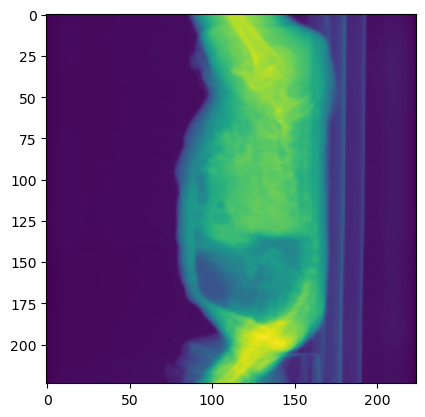

In [8]:
# plot the transformed image
import matplotlib.pyplot as plt
# scale the pixel values back to [0, 255]
plt.imshow(transformed[0][0][0,:,:])

In [14]:
type(transformed[0][1])

numpy.float32

In [15]:
type(transformed[0][0][0,0,0])

torch.Tensor

In [16]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision.models.resnet import ResNet18_Weights

In [17]:
# Load a pretrained ResNet model
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the fully connected layer
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)  # Regression output layer

# Print the modified model (optional)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# train/validation split
train_set, val_set = torch.utils.data.random_split(transformed, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

In [19]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 20
batch_size = 32

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)

# Assuming you have your dataset ready
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
print("Device:", device)

Device: cuda


In [20]:
# Initialize lists to store losses
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    resnet.train()
    running_train_loss = 0.0
    
    # Training loop
    for inputs, targets in train_loader:
        inputs, targets = inputs.float().to(device), targets.float().to(device)

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Compute the average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop (no gradients needed)
    resnet.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.float().to(device), targets.float().to(device)

            outputs = resnet(inputs)
            loss = criterion(outputs.squeeze(), targets)
            running_val_loss += loss.item()

    # Compute the average validation loss for this epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/20], Train Loss: 5717.1597, Val Loss: 3177.1108
Epoch [2/20], Train Loss: 4781.7801, Val Loss: 3324.2118
Epoch [3/20], Train Loss: 4107.2494, Val Loss: 1522.1721
Epoch [4/20], Train Loss: 3415.1077, Val Loss: 1860.6301
Epoch [5/20], Train Loss: 2731.6351, Val Loss: 2753.3362
Epoch [6/20], Train Loss: 2065.4125, Val Loss: 1879.7883
Epoch [7/20], Train Loss: 1460.4810, Val Loss: 1287.7274
Epoch [8/20], Train Loss: 965.1861, Val Loss: 718.8963
Epoch [9/20], Train Loss: 591.2358, Val Loss: 54.5882
Epoch [10/20], Train Loss: 345.8075, Val Loss: 97.8975
Epoch [11/20], Train Loss: 200.2958, Val Loss: 251.1788
Epoch [12/20], Train Loss: 109.7237, Val Loss: 58.6732
Epoch [13/20], Train Loss: 57.8798, Val Loss: 93.3557
Epoch [14/20], Train Loss: 42.4342, Val Loss: 229.2862
Epoch [15/20], Train Loss: 36.0690, Val Loss: 83.3616
Epoch [16/20], Train Loss: 37.8238, Val Loss: 65.1824
Epoch [17/20], Train Loss: 26.8409, Val Loss: 139.3673
Epoch [18/20], Train Loss: 23.3843, Val Loss: 63.5848


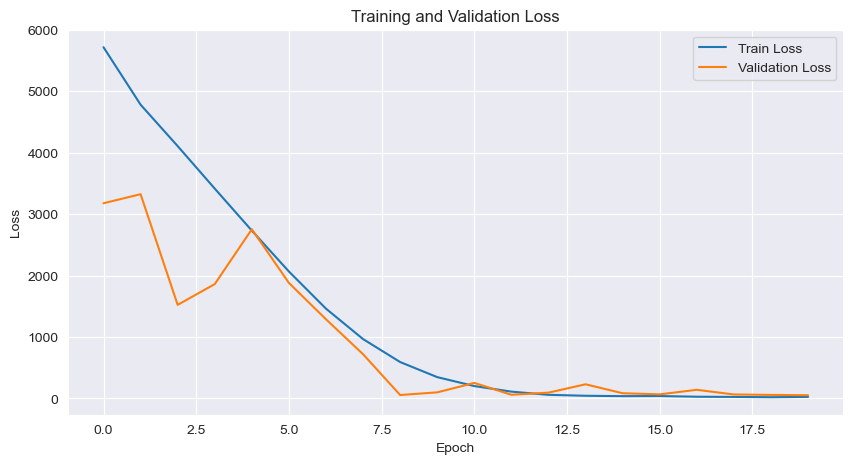

In [21]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
# Save the trained model
torch.save(resnet.state_dict(), "resnet18CT_Rudimentary.pth")